Import !

In [157]:
import numpy as np
import scipy
from scipy import stats
from scipy.optimize import fmin_cg
import matplotlib.pyplot as plt

Define number of Gaussian Mixture Model Components and Sample dimension.

In [158]:
num_gmm_components = 3
num_dimensions = 2

Define class for Gaussian Mixture Models
- Here, mixture weights and number of mixture components are not optimized
- Mixture Weights are always uniform
- All mixture covariances are integer (that is, variance*Identity matrix)
- Optimized parametes are: Vector Means and Scalar Variances

In short,

$P(x; \theta) = \sum_{k=1}^M \frac{1}{M} \mathcal{N}(x; \overline{\mu}_k, \sigma_k^2)$ 

where $\theta := \{\overline{\mu}_k, \sigma_k; k= 1, 2, ... M \}$ 

and $\mathcal{N}(x; \overline{\mu}, \sigma^2) = \frac{1}{(2\pi)^{0.5D}\sigma D^{0.5}} exp[- \frac{1}{2\sigma^2}\|x - \overline{\mu} \|^2]$

In [159]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class GaussianMixtureModel():
    def __init__(self, n, d, means, sigmas , weights = None):
        super().__init__()
        self.n = n
        self.d = d
        assert len(means) == n*d
        assert len(sigmas) == n
        means = np.reshape(means, (n, d))
        
        self.models = []
        for i in range(self.n):
            self.models.append(stats.multivariate_normal(mean=means[i], cov=sigmas[i]**2))
        
        if weights is None:
            self.w = [1/self.n for _ in range(self.n)]
        else:
            assert len(weights) == self.n
            assert sum(weights) == 1
            self.w = weights
    
    def _pdf(self, x):
        pdf = 0.0
        for i in range(self.n):
            pdf += self.models[i].pdf(x)  * self.w[i]
        return pdf
    
    def _rvs(self, N):
        z = np.random.choice( self.n, size=N, p = self.w).reshape((N , 1))
        samples = [model.rvs(size=N).tolist() for model in self.models]
        
        rvs = np.choose(z, samples)
        return rvs
    
    def _update_params(self, means, sigmas):
        assert len(means) == self.n * self.d
        means = np.reshape(means, (self.n, self.d))
        self.models.clear()
        
        for i in range(self.n):
            self.models.append(stats.multivariate_normal(mean=means[i], cov=sigmas[i]**2))
    
    # Not used when grad fn to fmin_cg is not supplied (grad not implemented as of now)
    def _grad_mu(self, x, gmm_component, vector_component=0):
        k = gmm_component
        j = vector_component
        f = self.models[k]
        w = self.w[k]
        grad = f.pdf(x)  * w[k]
        grad = grad * (x[j] - f.mean[j])
        grad = grad / f.cov[0,0] 
        return grad

    def _grad_sigma2(self, x, gmm_component):
        k = gmm_component
        f = self.models[k]
        w = self.w[k]
        norm2 = scipy.linalg.norm(x - f.mean)**2
        grad = f.pdf(x)  * w[k]
        grad = grad * ((norm2/f.cov[0,0]) - 1.0)
        grad = grad / f.cov[0,0]**0.5 
        return grad

    def _print(self):
        for i in range(self.n):
            print(i, self.models[i].mean, self.models[i].cov)
    
    def _plot(self):
        x, y = np.mgrid[-10:10:.1, -10:10:.1]
        data = np.dstack((x, y))
        z = self._pdf(data)
        plt.contourf(x, y, z, cmap='coolwarm')
        plt.show()

Samples from true (unknown) distribution: $P_d(x)$

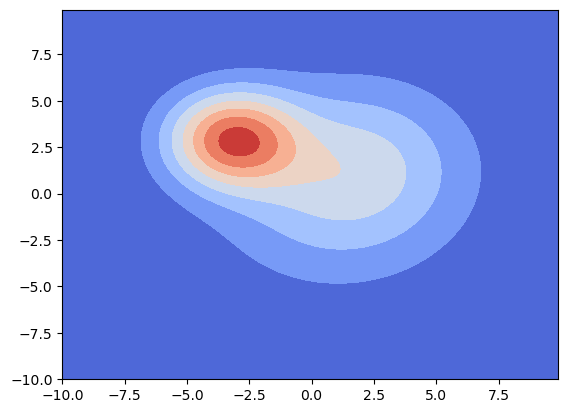

In [160]:
N = 5000 # number of datasamples
true_mean = np.random.uniform(low=-4, high=5, size=(num_dimensions*num_gmm_components,))
true_sigmas = np.random.uniform(low=1, high=4, size=(num_gmm_components,))
gmm_data = GaussianMixtureModel(num_gmm_components, num_dimensions,means=true_mean, sigmas=true_sigmas)
X = gmm_data._rvs(N)
gmm_data._plot()

Samples from noise distribution: $P_n(x)$.

Note that noise distribution is not a mixture but a single multivariate gaussian.

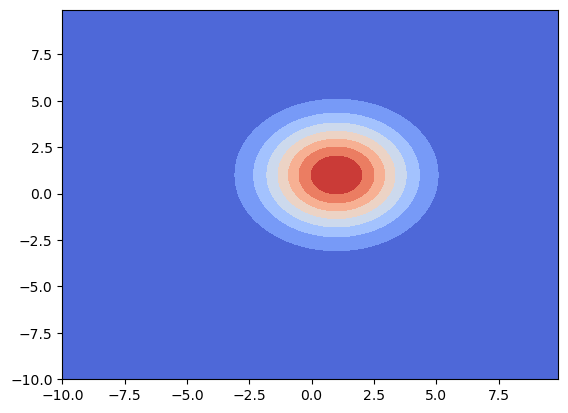

In [161]:
Y = []
gmm_noise = GaussianMixtureModel(1, 2, means=[1, 1], sigmas=[2])
Y = gmm_noise._rvs(N)
gmm_noise._plot()

Set up statistical model $P_m(x;\theta)$ with initial values of params $\theta_0$ to be estimated.

In [162]:
theta_mean = [-1, 0, 1, 1, 2, 3]
theta_cov = [1.1**0.5, 2**0.5, 1]
gmm_model = GaussianMixtureModel(num_gmm_components, num_dimensions, means=theta_mean, sigmas=theta_cov)

Define objective function $J(\theta)$ to be used.

In [163]:
def J(x, *args):
    X, Y, n, d = args
    means, covs = x[:n*d], x[n*d:]
    gmm_model._update_params(means=means, sigmas=covs)
    P_m_x = gmm_model._pdf(X)
    P_m_y = gmm_model._pdf(Y)
    P_n_x = gmm_noise._pdf(X)
    P_n_y = gmm_noise._pdf(Y)
    
    h_x = sigmoid(np.log(P_m_x/P_n_x))
    h_y = sigmoid(np.log(P_m_y/P_n_y))

    J = np.log(h_x) + np.log(1 - h_y)
    return sum(-J)

Perform Conjugate Gradient Ascent on the objective function. 

Note that the function below can compute gradient automatically.

In [164]:
res1 = fmin_cg(J, theta_mean + theta_cov, args=(X,Y,  num_gmm_components, num_dimensions))

         Current function value: 5322.883603
         Iterations: 74
         Function evaluations: 2343
         Gradient evaluations: 233


/Users/dhruvbhardwaj/anaconda3/envs/work-nd/lib/python3.11/site-packages/scipy/optimize/_optimize.py:1698: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, **opts)


Plot true and estimated distributions: $P_d(x)$ and $P_m(x;\theta^*)$.

True distribution


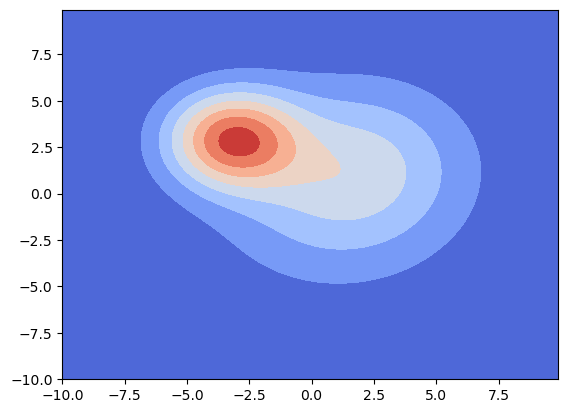

--
Esimated distribution


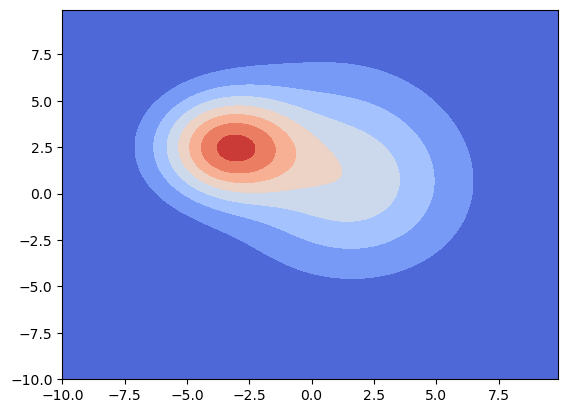

In [166]:
print('True distribution')
gmm_data._plot()
print('--')
print('Esimated distribution')
gmm_model._plot()